In [1]:
from datetime import datetime

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim

import numpy as np


In [2]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Load datasets
train_dataset = ImageFolder('worm_categories/train', transform=train_transforms)
val_dataset = ImageFolder('worm_categories/val', transform=val_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load a pre-trained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)


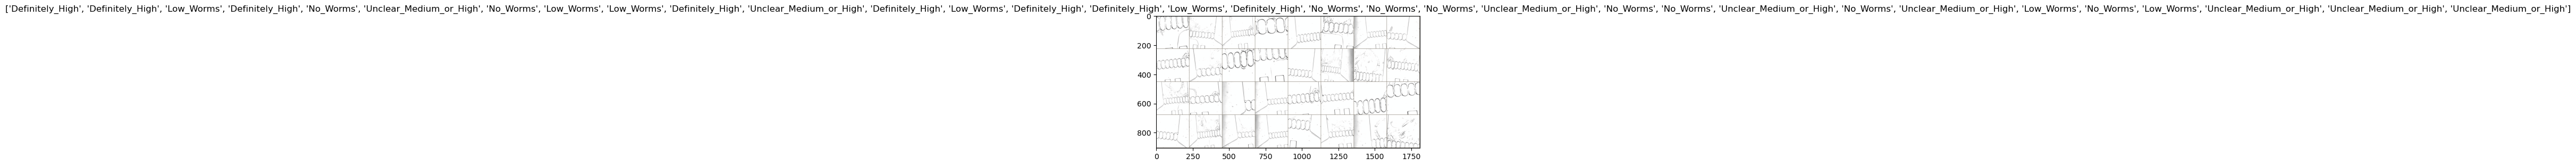

In [4]:
# val_dataset[0]
# for i, (inputs, labels) in enumerate(train_loader):
#     print(f'Batch {i}:')
#     print(f' - Tensor size: {inputs.size()}')
#     print(f' - Labels: {labels}')
#     if i == 1:  # just check a couple of batches to confirm
#         break
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_dataset.classes[x] for x in classes])


In [5]:
# Replace the last fully connected layer with a layer matching the number of categories (4 in this case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

In [6]:
# Move the model to the GPU if available
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device = torch.device(device)
device = "cpu"
model = model.to(device)

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [34]:
num_epochs = 25  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # At the end of each training epoch, validate the model
    model.eval()  # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Disabling gradient calculation is important for validation.
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)

    print(f'Epoch {epoch}/{num_epochs - 1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Epoch {epoch}/{num_epochs - 1} Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

now = datetime.utcnow().strftime('%Y-%m-%d_%H%M'))
torch.save(model.state_dict(), f"models/model_weights_{now}.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'worm_categories/val/Definitely_High/image_2131.tif'

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:

now = datetime.utcnow().strftime('%Y-%m-%d_%H%M')
f"models/model_weights_{now}.pth"


'models/model_weights_2023-11-08_1707.pth'